In [ ]:
!pip install keras-cv keras-core -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
import os
import logging
import warnings as wr
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_cv as kcv
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_core as kc
import keras_core.layers as kcl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend


In [ ]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

In [ ]:
!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz

--2023-11-10 22:34:16--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c06::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229962973 (219M) [application/octet-stream]
Saving to: ‘public_data_clean_balanced_splitted.npz’

public_data_clean_b 100%[===================>] 219.31M  23.0MB/s    in 10s     

2023-11-10 22:34:28 (21.2 MB/s) - ‘public_data_clean_balanced_splitted.npz’ saved [229962973/229962973]



In [ ]:
X_train_val, y_train_val, X_test, y_test = np.load('public_data_clean_balanced_splitted.npz', allow_pickle=True).values()

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val
)

y_train = kc.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = kc.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = kc.utils.to_categorical(y_test,len(np.unique(y_test)))

In [ ]:
batch_size = 32
image_size = 96
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

# Get the Shape of IN OUT
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

train_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.ragged_batch(batch_size)
val_ds = val_ds.ragged_batch(batch_size)

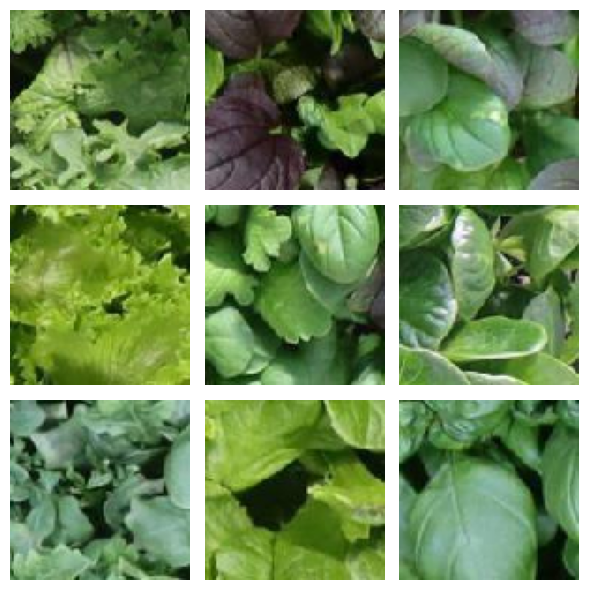

In [ ]:
batch = next(iter(train_ds.take(1)))
image_batch = batch[0]
label_batch = batch[1]

kcv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

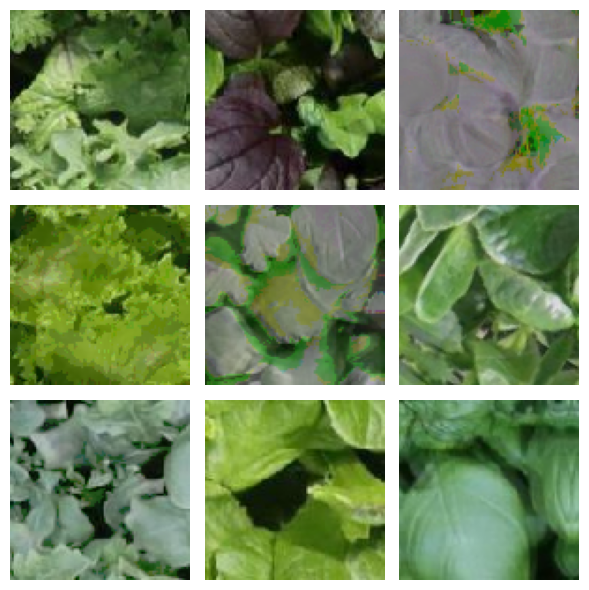

In [ ]:
augmix = kcv.layers.AugMix([0, 255])
augmenters = [augmix]

image_batch = augmix(image_batch)
kcv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

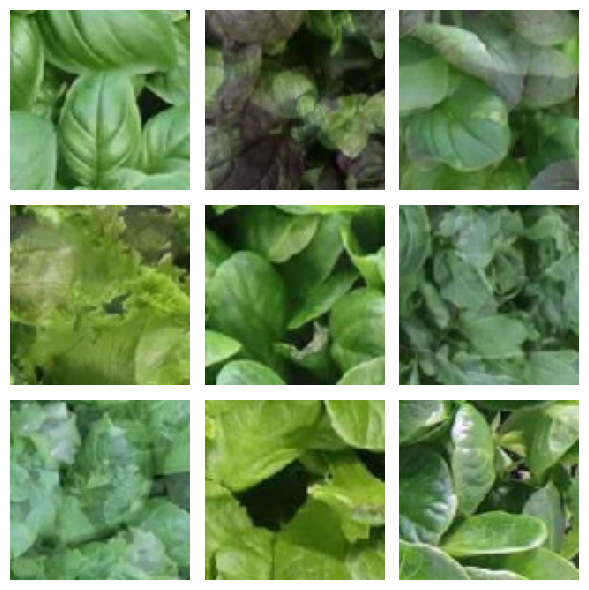

In [ ]:
mix_up = kcv.layers.MixUp()
# MixUp needs to modify both images and labels
inputs = {"images": image_batch, "labels": label_batch}

kcv.visualization.plot_image_gallery(
    mix_up(inputs)["images"],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

#cut_mix_or_mix_up = kcv.layers.RandomChoice([cut_mix, mix_up], batchwise=True)
#augmenters += [cut_mix_or_mix_up]

In [ ]:
from keras_core.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  # TO CHANGE - res of the Model
  backbone = kc.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  backbone.trainable = False

  input_layer = kcl.Input(input_shape, name="AE_input_layer")

  x = preprocess_input(input_layer)
  x = backbone(x)
  x = kcl.GlobalAveragePooling2D(name="AE_global_average_pooling2d")(x)
  x = kcl.Dense(units=128,activation=kcl.LeakyReLU(alpha=0.1), name="AE_dense")(x)
  x = kcl.Dropout(0.6, name="AE_dropout")(x)
  output_layer = kcl.Dense(units=output_shape,activation='softmax', name="AE_output_layer")(x)


  model = kc.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=kc.losses.CategoricalCrossentropy(),
      optimizer=kc.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model

model = apple_elixir_model(input_shape,output_shape)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
EPOCHS = 200

# Train the model
early_stopping = kc.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = kc.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks = callbacks
).history

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 64s 928ms/step - accuracy: 0.5089 - loss: 0.9792 - val_accuracy: 0.5736 - val_loss: 0.6972 - learning_rate: 1.0000e-04
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.5510 - loss: 0.8482 - val_accuracy: 0.6466 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6158 - loss: 0.6941 - val_accuracy: 0.7452 - val_loss: 0.5657 - learning_rate: 1.0000e-04
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.6342 - loss: 0.6441 - val_accuracy: 0.7567 - val_loss: 0.5371 - learning_rate: 1.0000e-04
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.6702 - loss: 0.6099 - val_accuracy: 0.7900 - val_loss: 0.5081 - learning_rate: 1.0000e-04
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7047 - loss: 0.5681 - val_accuracy: 0.8003 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - a

In [ ]:
NAME_MODEL = "ConvNeXtCV_001"
NAME_PLOT = NAME_MODEL + "_plot"

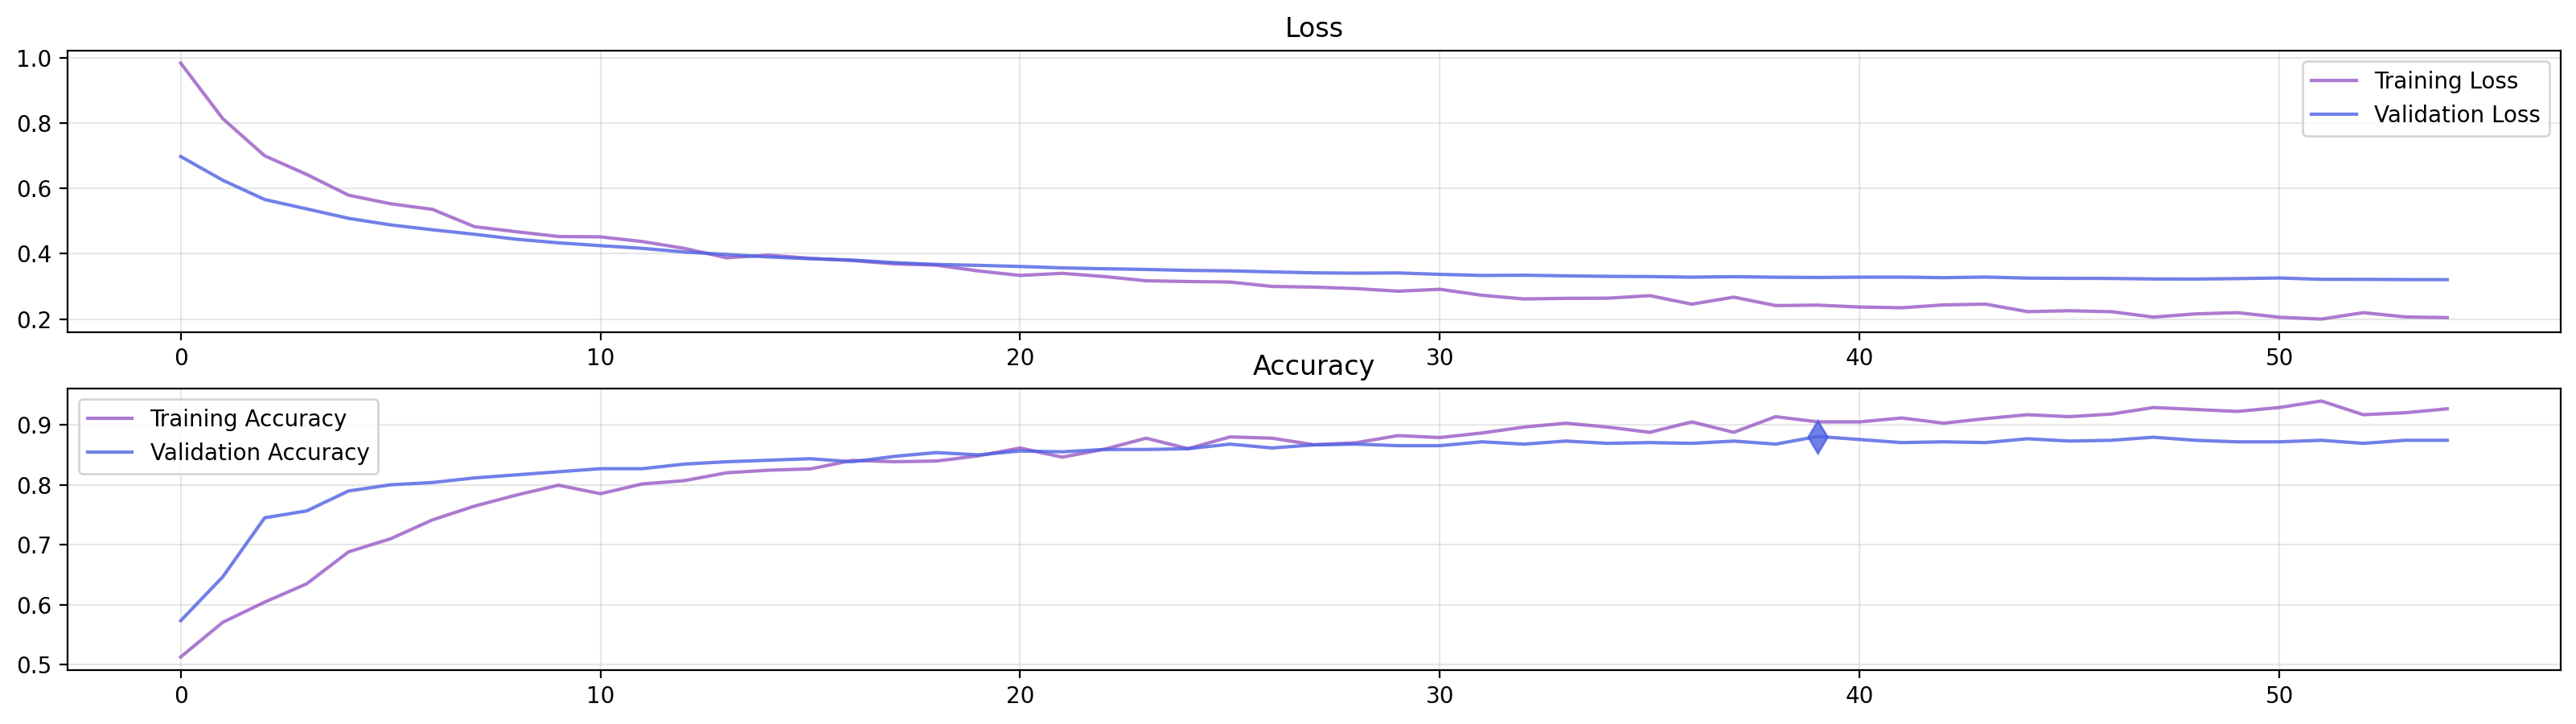

Accuracy Score over the Test Set: 0.939



In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 0.939
Precision: 0.9391
Recall: 0.939
F1: 0.939


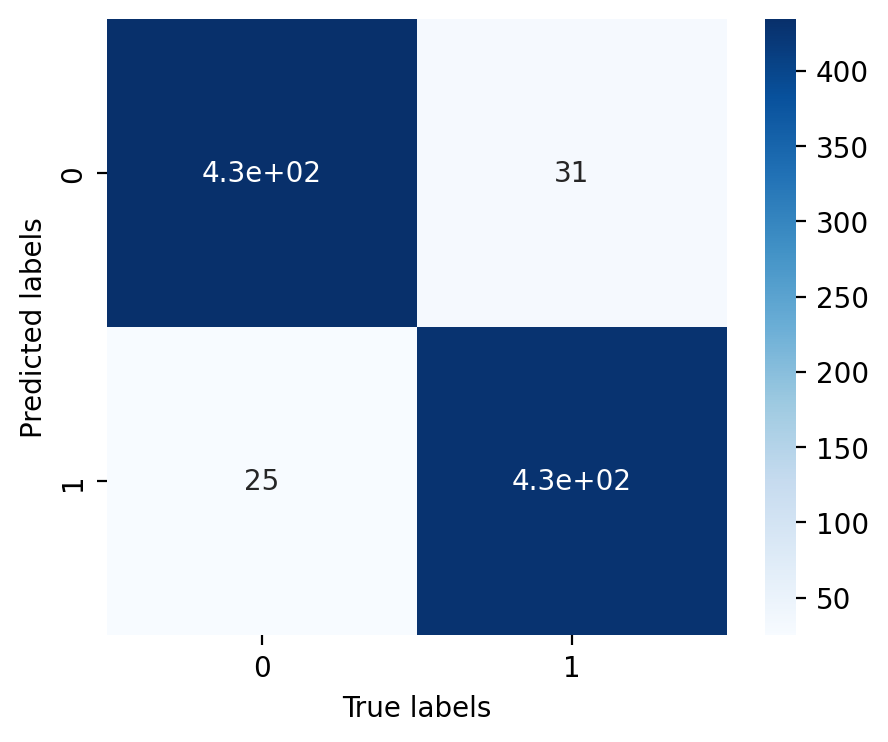

In [ ]:
# Compute the confusion matrix
test_predictions = model.predict(X_test, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(5, 4), dpi=200)
sns.heatmap(cm.T, annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [36]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 AE_input_layer
1 convnext_base
2 AE_global_average_pooling2d
3 AE_dense
4 AE_dropout
5 AE_output_layer


In [41]:
for i, weight in enumerate(model.weights):
  model.weights[i].name += f'_{i}'

In [42]:
for i, weight in enumerate(model.weights):
  print(i, weight.name)

0 kernel_0
1 bias_1
2 gamma_2
3 beta_3
4 kernel_4
5 bias_5
6 gamma_6
7 beta_7
8 kernel_8
9 bias_9
10 kernel_10
11 bias_11
12 variable_12
13 kernel_13
14 bias_14
15 gamma_15
16 beta_16
17 kernel_17
18 bias_18
19 kernel_19
20 bias_20
21 variable_1_21
22 kernel_22
23 bias_23
24 gamma_24
25 beta_25
26 kernel_26
27 bias_27
28 kernel_28
29 bias_29
30 variable_2_30
31 gamma_31
32 beta_32
33 kernel_33
34 bias_34
35 kernel_35
36 bias_36
37 gamma_37
38 beta_38
39 kernel_39
40 bias_40
41 kernel_41
42 bias_42
43 variable_3_43
44 kernel_44
45 bias_45
46 gamma_46
47 beta_47
48 kernel_48
49 bias_49
50 kernel_50
51 bias_51
52 variable_4_52
53 kernel_53
54 bias_54
55 gamma_55
56 beta_56
57 kernel_57
58 bias_58
59 kernel_59
60 bias_60
61 variable_5_61
62 gamma_62
63 beta_63
64 kernel_64
65 bias_65
66 kernel_66
67 bias_67
68 gamma_68
69 beta_69
70 kernel_70
71 bias_71
72 kernel_72
73 bias_73
74 variable_6_74
75 kernel_75
76 bias_76
77 gamma_77
78 beta_78
79 kernel_79
80 bias_80
81 kernel_81
82 bias_82
83

In [35]:
model.layers[0].name = "AE_input_layer"
model.layers[2].name = "AE_global_average_pooling2d"
model.layers[3].name = "AE_dense"
model.layers[4].name = "AE_dropout"
model.layers[5].name = "AE_output_layer"

In [43]:
model.save(NAME_MODEL + '.h5')

In [24]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
! cp ConvNeXtCV_001.zip gdrive/MyDrive/

In [26]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL + '.tf'} {NAME_PLOT}.png

  adding: ConvNeXtCV_001.tf/ (stored 0%)
  adding: ConvNeXtCV_001.tf/variables/ (stored 0%)
  adding: ConvNeXtCV_001.tf/variables/variables.index (deflated 79%)
  adding: ConvNeXtCV_001.tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtCV_001.tf/saved_model.pb (deflated 93%)
  adding: ConvNeXtCV_001.tf/fingerprint.pb (stored 0%)
  adding: ConvNeXtCV_001.tf/assets/ (stored 0%)
  adding: ConvNeXtCV_001_plot.png (deflated 14%)


In [31]:
del ft_model

In [44]:
ft_model = kc.models.load_model(NAME_MODEL + '.h5')

ValueError: ignored

In [29]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print(c)

AttributeError: ignored